In [21]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from examples.models.initializer import initialize_torchvision_model
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split

import suitability.filter.tests as ftests
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter.sample_signals import (
    ConfidenceSignal,
    CorrectnessSignal,
    LogitSignal,
    LossGradientSignal,
    LossSignal,
)

random.seed(32)
np.random.seed(32)

In [2]:
def remove_prefix_from_state_dict(state_dict, prefix="model."):
    """
    Remove the prefix from the keys in state_dict if it exists.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix) :]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

## Train Regressor

In [3]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "fmow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

tuning_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Americas"},
)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def get_suitability_features(model, device, data):
    conf_signal = ConfidenceSignal(model, device)
    conf_mean = conf_signal.evaluate(data, "mean")
    conf_max = conf_signal.evaluate(data, "max")
    conf_std = conf_signal.evaluate(data, "std")
    # conf_min = conf_signal.evaluate(data, "min")
    # conf_median = conf_signal.evaluate(data, "median")
    # conf_entropy = conf_signal.evaluate(data, "entropy")
    # conf_diff_top2 = conf_signal.evaluate(data, "difference_between_top_two")

    logit_signal = LogitSignal(model, device)
    logit_mean = logit_signal.evaluate(data, "mean")
    logit_max = logit_signal.evaluate(data, "max")
    logit_std = logit_signal.evaluate(data, "std")
    # logit_min = logit_signal.evaluate(data, "min")
    # logit_median = logit_signal.evaluate(data, "median")

    loss_signal = LossSignal(model, device)
    loss = loss_signal.evaluate(data)

    loss_grad_signal = LossGradientSignal(model, device)
    loss_grad = loss_grad_signal.evaluate(data, mode="mean")

    features = np.column_stack(
        (
            conf_mean,
            conf_max,
            conf_std,
            logit_mean,
            logit_max,
            logit_std,
            loss,
            loss_grad,
        )
    )

    return features

In [5]:
calibrated = True

corr_signal = CorrectnessSignal(model, device)
labels = corr_signal.evaluate(tuning_data)

features = get_suitability_features(model, device, tuning_data)

# Split data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=32
)

# Initialize the logistic regression model
regression_model = LogisticRegression()

if not calibrated:
    reg_model = regression_model
else:
    reg_model = CalibratedClassifierCV(
        regression_model, method="isotonic"
    )  # 'sigmoid' for Platt scaling, 'isotonic' for Isotonic Regression

reg_model.fit(X_train, y_train)

# Predict probabilities on the test set (probability of label being 1)
y_pred_prob = reg_model.predict_proba(X_test)[:, 1]  # Get the probability for class 1

# Evaluate model performance (accuracy, AUC)
accuracy = accuracy_score(y_test, reg_model.predict(X_test))
auc_score = roc_auc_score(y_test, y_pred_prob)

if not calibrated:
    print(f"Intercept: {reg_model.intercept_}, Coefficients: {reg_model.coef_}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC Score: {auc_score:.2f}")
print(f"Brier Score: {brier_score_loss(y_test, y_pred_prob):.2f}")

Accuracy: 0.75
AUC Score: 0.82
Brier Score: 0.17


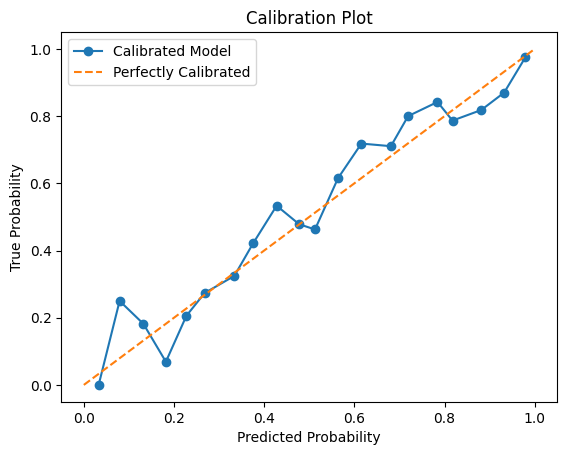

In [6]:
# Get calibration curve data
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=20)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Plot")
plt.legend()
plt.show()


## Hypothesis Test (Region)

In [7]:
# Determine data splits
REGIONS = ["Asia", "Europe", "Africa", "Americas", "Oceania"]

# Construct suitability filter
features = {}
correctness = {}

for region in REGIONS:
    reg_data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"region": region},
    )

    features[region] = get_suitability_features(model, device, reg_data)
    print(f"Region {region}: {features[region].shape[0]} samples")

    corr_signal = CorrectnessSignal(model, device)
    correctness[region] = corr_signal.evaluate(reg_data)

    print(f"Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct")

Region Asia: 4963 samples
Region Asia: 55.35% correct
Region Europe: 5858 samples
Region Europe: 56.16% correct
Region Africa: 2593 samples
Region Africa: 32.78% correct
Region Americas: 8024 samples
Region Americas: 56.72% correct
Region Oceania: 666 samples
Region Oceania: 59.46% correct


In [8]:
# Test the suitability filter
bm_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Asia"},
)
bm_features = get_suitability_features(model, device, bm_data)
bm_dist = reg_model.predict_proba(bm_features)[:, 1]
corr_signal = CorrectnessSignal(model, device)
print(f"BM Accuracy: {np.mean(corr_signal.evaluate(bm_data)) * 100:.2f}% correct")

BM Accuracy: 56.10% correct


In [22]:
test_fn = ftests.non_inferiority_ttest
margin = 0.01
reg_dists = {}

for region in REGIONS:
    print(f"Region {region}:")
    reg_dist = reg_model.predict_proba(features[region])[:, 1]
    reg_dists[region] = reg_dist
    nit = test_fn(bm_dist, reg_dist, margin=margin)
    print("Non-inferiority-test", nit)
    if nit["p_value"] < 0.05:
        print(
            "Power",
            ftests.power_non_inferiority_ttest(bm_dist, reg_dist, margin=margin),
        )
        print(
            "Sample size",
            ftests.sample_size_non_inferiority_ttest(
                bm_dist, reg_dist, power=0.8, margin=margin
            ),
        )

Region Asia:
Non-inferiority-test {'t_statistic': -1.198084676547035, 'p_value': 0.1154581940013489, 'reject_null': False}
Region Europe:
Non-inferiority-test {'t_statistic': -2.0233072522510764, 'p_value': 0.021535167093938854, 'reject_null': True}
Power 0.8685952235358734
Sample size 3727
Region Africa:
Non-inferiority-test {'t_statistic': 14.976225796933221, 'p_value': 1.0, 'reject_null': False}
Region Americas:
Non-inferiority-test {'t_statistic': -4.009346349457306, 'p_value': 3.070225175271197e-05, 'reject_null': True}
Power 0.9991738477661344
Sample size 893
Region Oceania:
Non-inferiority-test {'t_statistic': -3.1449752542287754, 'p_value': 0.0008583015631306908, 'reject_null': True}
Power 0.9736548007006091
Sample size 297


## Hypothesis Test (Sample Size)

In [44]:
# Function to perform non-inferiority t-tests and calculate accuracy for different sample sizes across multiple trials
def run_non_inferiority_tests(reg_dists, bm_dist, sample_sizes, test_fn, n_trials=100, margin=0.01):
    results = []

    for sample_size in sample_sizes:
        for trial in range(n_trials):  # Multiple trials for each sample size
            row = {"sample_size": sample_size, "trial": trial}
            for region in REGIONS:  # Loop through regions
                # Sample from the region's confidence scores and correctness
                if sample_size >= len(reg_dists[region]):
                    row[f"p-value BM vs {region}"] = np.nan
                    row[f"t-statistic BM vs {region}"] = np.nan
                    row[f"power BM vs {region}"] = np.nan
                    row[f"sample size BM vs {region}"] = np.nan
                    continue

                sampled_indices = random.sample(range(len(reg_dists[region])), sample_size)
                reg_dist = [reg_dists[region][i] for i in sampled_indices]
                # Perform non-inferiority t-test between baseline (BM) and the sampled region
                res = test_fn(bm_dist, reg_dist, margin=margin)
                row[f"p-value BM vs {region}"] = res["p_value"]
                row[f"t-statistic BM vs {region}"] = res["t_statistic"]

                # If the p-value is below the threshold, calculate power and sample size
                if res["p_value"] < 0.05:
                    power = ftests.power_non_inferiority_ttest(bm_dist, reg_dist, margin=margin)
                    row[f"power BM vs {region}"] = power
                    try:
                        sample_size_required = ftests.sample_size_non_inferiority_ttest(bm_dist, reg_dist, power=0.8, margin=margin)
                        row[f"sample size BM vs {region}"] = sample_size_required
                    except TypeError:
                        row[f"sample size BM vs {region}"] = np.nan
                else:
                    row[f"power BM vs {region}"] = np.nan
                    row[f"sample size BM vs {region}"] = np.nan

            results.append(row)

    return pd.DataFrame(results)


# Define sample sizes to test
sample_sizes = [50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 1200, 1600, 2000, 2500, 3000, 4000, 4500, 5000, 6000, 7000, 8000]

# Run non-inferiority tests for different sample sizes
test_results = run_non_inferiority_tests(
    reg_dists,
    bm_dist,
    sample_sizes,
    ftests.non_inferiority_ttest,
    n_trials=100,
    margin=0,
)

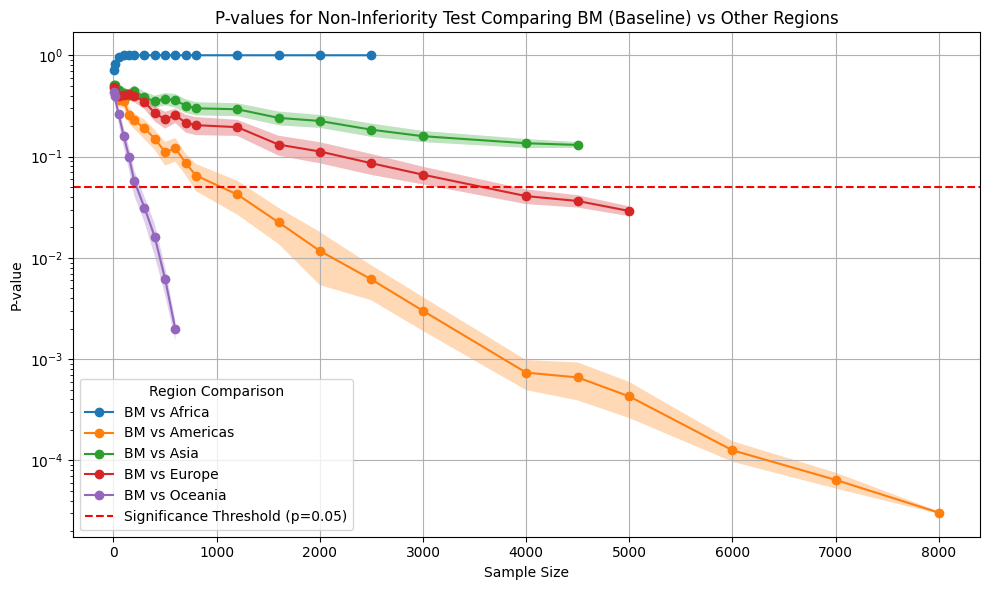

In [39]:
df_melted = test_results.melt(id_vars=['sample_size', 'trial'], value_vars=['p-value BM vs Americas', 'p-value BM vs Asia', 'p-value BM vs Africa', 'p-value BM vs Europe', 'p-value BM vs Oceania'],
                    var_name='Comparison', value_name='p-value')

df_melted['Comparison'] = df_melted['Comparison'].str.replace('p-value BM vs ', 'BM vs ')

df_summary = df_melted.groupby(['sample_size', 'Comparison']).agg(
    p_value_mean=('p-value', 'mean'),
    p_value_std=('p-value', 'std'),
    n=('p-value', 'size')
).reset_index()

df_summary['ci_upper'] = df_summary['p_value_mean'] + 1.96 * (df_summary['p_value_std'] / np.sqrt(df_summary['n']))
df_summary['ci_lower'] = df_summary['p_value_mean'] - 1.96 * (df_summary['p_value_std'] / np.sqrt(df_summary['n']))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the mean p-values for each comparison
for comparison in df_summary['Comparison'].unique():
    subset = df_summary[df_summary['Comparison'] == comparison]
    plt.plot(subset['sample_size'], subset['p_value_mean'], marker='o', label=comparison)

    # Plot the confidence intervals as shaded regions
    plt.fill_between(subset['sample_size'], subset['ci_lower'], subset['ci_upper'], alpha=0.3)

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title('P-values for Non-Inferiority Test Comparing BM (Baseline) vs Other Regions')
plt.xlabel('Sample Size')
plt.ylabel('P-value')
plt.yscale('log')  # Optional: Use logarithmic scale for p-values
plt.legend(title='Region Comparison')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Hypothesis Test (Accuracy)

In [22]:
data = get_wilds_dataset(
    dataset_name, root_dir, "test", batch_size=64, shuffle=False, num_workers=4
)

max_conf_signal = ConfidenceSignal(model, device)
max_confidences = max_conf_signal.evaluate(data, "max")
mean_conf_signal = ConfidenceSignal(model, device)
mean_confidences = mean_conf_signal.evaluate(data, "mean")
std_conf_signal = ConfidenceSignal(model, device)
std_confidences = std_conf_signal.evaluate(data, "std")

max_logit_signal = LogitSignal(model, device)
max_logits = max_logit_signal.evaluate(data, "max")
mean_logit_signal = LogitSignal(model, device)
mean_logits = mean_logit_signal.evaluate(data, "mean")
std_logit_signal = LogitSignal(model, device)
std_logits = std_logit_signal.evaluate(data, "std")

corr_signal = CorrectnessSignal(model, device)
correctness = corr_signal.evaluate(data)

In [28]:
def evaluate_suitability_fmow(n_subsets):
    # Number of subsets and target accuracies
    target_accuracies = np.linspace(0.3, 0.75, n_subsets)
    total_samples = len(correctness)

    # Shuffle the data to randomize distribution
    indices = np.random.permutation(total_samples)
    shuffled_correctness = correctness[indices]
    shuffled_mean_confidences = mean_confidences[indices]
    shuffled_max_confidences = max_confidences[indices]
    shuffled_std_confidences = std_confidences[indices]
    shuffled_mean_logits = mean_logits[indices]
    shuffled_max_logits = max_logits[indices]
    shuffled_std_logits = std_logits[indices]

    # Create subsets with specific accuracies
    subsets_regression_mean = [None] * n_subsets
    subsets_p_value = [None] * n_subsets
    subset_accuracies = [None] * n_subsets
    start_idx = 0

    for i, target_accuracy in enumerate(target_accuracies):
        # Calculate the number of correct and incorrect samples needed for the subset
        subset_size = total_samples // n_subsets
        n_correct = int(subset_size * target_accuracy)
        n_incorrect = subset_size - n_correct

        # Find the correct/incorrect samples in the shuffled data
        correct_indices = np.where(shuffled_correctness[start_idx:] == 1)[0][:n_correct]
        incorrect_indices = np.where(shuffled_correctness[start_idx:] == 0)[0][
            :n_incorrect
        ]

        # Get the final indices for the current subset
        subset_indices = (
            np.concatenate((correct_indices, incorrect_indices)) + start_idx
        )

        # Extract the subset from correctness and logits arrays
        feature = np.column_stack(
            (
                shuffled_mean_confidences[subset_indices],
                shuffled_max_confidences[subset_indices],
                shuffled_std_confidences[subset_indices],
                shuffled_mean_logits[subset_indices],
                shuffled_max_logits[subset_indices],
                shuffled_std_logits[subset_indices],
            )
        )
        correctness_subset = shuffled_correctness[subset_indices]
        regression_subset = regression_model.predict_proba(feature)[:, 1]

        # Move the start index forward
        start_idx += len(subset_indices)

        # Print the achieved accuracy
        # accuracy = np.mean(subsets_correctness[i])
        # subset_size = len(subset_indices)
        # print(
        #     f"Subset of size {subset_size} with target accuracy {target_accuracy:.2f}: Achieved accuracy = {accuracy:.2f}"
        # )

        subsets_regression_mean[i] = np.mean(regression_subset)
        subsets_p_value[i] = test_fn(bm_dist, regression_subset, margin=0)["p_value"]
        subset_accuracies[i] = np.mean(correctness_subset)

    return subsets_regression_mean, subsets_p_value, subset_accuracies

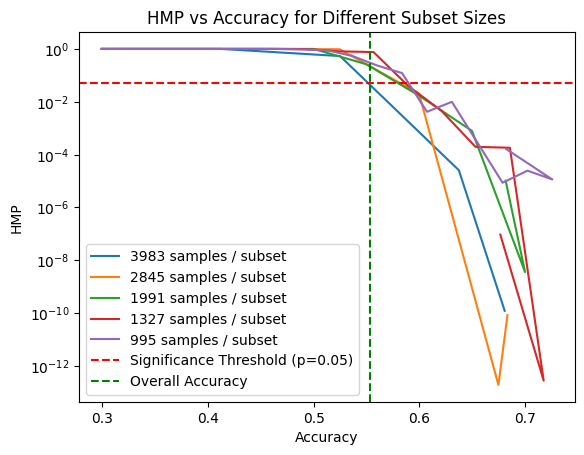

In [30]:
subset_cnt = [5, 7, 10, 15, 20]
test_fn = ftests.non_inferiority_ttest

for cnt in subset_cnt:
    subsets_regression_mean, subsets_p_value, subset_accuracies = (
        evaluate_suitability_fmow(cnt)
    )
    plt.plot(
        subset_accuracies, subsets_p_value, label=f"{len(corr)//cnt} samples / subset"
    )

plt.xlabel("Accuracy")
plt.ylabel("HMP")
plt.yscale("log")
plt.axhline(
    y=0.05, color="red", linestyle="--", label="Significance Threshold (p=0.05)"
)
plt.axvline(x=0.553, color="green", linestyle="--", label="Overall Accuracy")
plt.title("HMP vs Accuracy for Different Subset Sizes")
plt.legend()
plt.show()